In [13]:
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from torch.amp import GradScaler
import datetime
import json

torch.cuda.empty_cache()

In [14]:
class RareDiseaseFewShotDataset(Dataset):
    def __init__(self, root_dir, transform=None, n_way=7, k_shot=5, k_query=5, num_tasks=1000):
        self.root_dir = root_dir
        self.transform = transform
        self.k_shot = k_shot
        self.k_query = k_query
        self.num_tasks = num_tasks

        class_names = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])
        if len(class_names) == 0:
            raise ValueError("No classes found in the dataset!")

        self.n_way = min(n_way, len(class_names))
        self.class_to_idx = {class_name: idx for idx, class_name in enumerate(class_names)}
        
        # Load image paths for each class
        self.image_files = {class_name: [] for class_name in class_names}
        for class_name in class_names:
            class_path = os.path.join(root_dir, class_name)
            images = [
                os.path.join(class_path, file)
                for file in os.listdir(class_path)
                if file.lower().endswith((".jpg", ".jpeg", ".png"))
            ]
            self.image_files[class_name] = images

    def sample_task(self):
        """Samples an N-way, K-shot + K-query few-shot learning task."""
        sampled_classes = random.sample(list(self.image_files.keys()), self.n_way)
        support_set, query_set = [], []

        for class_name in sampled_classes:
            label = self.class_to_idx[class_name]
            num_images = len(self.image_files[class_name])

            # Ensure enough images, allow re-sampling if needed
            selected_images = random.choices(self.image_files[class_name], k=self.k_shot + self.k_query)

            support_set.extend([(img_path, label) for img_path in selected_images[:self.k_shot]])
            query_set.extend([(img_path, label) for img_path in selected_images[self.k_shot:]])
        return support_set, query_set

    def load_images(self, image_list):
        """Efficiently loads images and converts them to tensors."""
        images = [self.transform(Image.open(img_path).convert("RGB")) for img_path, _ in image_list]
        labels = [label for _, label in image_list]
        return torch.stack(images), torch.tensor(labels, dtype=torch.long)

    def __getitem__(self, _):
        """Generates one few-shot task."""
        support_set, query_set = self.sample_task()
        support_images, support_labels = self.load_images(support_set)
        query_images, query_labels = self.load_images(query_set)
        return support_images, support_labels, query_images, query_labels

    def __len__(self):
        return self.num_tasks

In [15]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [16]:
dataset_root = "data/data_split_rare_disease/train"
fewshot_dataset = RareDiseaseFewShotDataset(dataset_root, transform, n_way=7, k_shot=5, k_query=5)
fewshot_dataloader = DataLoader(fewshot_dataset, batch_size=1, shuffle=False)

test_dataset = RareDiseaseFewShotDataset("data/data_split_rare_disease/test", transform, n_way=7, k_shot=5, k_query=5)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)


In [17]:
class ProtoNet(nn.Module):
    def __init__(self, backbone="resnet", embedding_dim=128, num_classes=7, pretrained_path=None):
        super(ProtoNet, self).__init__()
        backbone = backbone.lower()
        
        if backbone == "resnet":
            model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
            self.feature_extractor = nn.Sequential(*list(model.children())[:-1])
            feature_dim = model.fc.in_features
        elif backbone == "regnety":
            model = models.regnet_y_400mf(weights=models.RegNet_Y_400MF_Weights.DEFAULT)
            self.feature_extractor = nn.Sequential(*list(model.children())[:-1])
            feature_dim = model.fc.in_features
        elif backbone == "efficientnet":
            model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
            self.feature_extractor = model.features  
            feature_dim = model.classifier[1].in_features
        elif backbone == "convnext":
            model = models.convnext_tiny(weights=models.ConvNeXt_Tiny_Weights.DEFAULT)
            self.feature_extractor = nn.Sequential(*list(model.children())[:-1])
            feature_dim = model.classifier[2].in_features
        elif backbone == "mobilenet":
            model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
            self.feature_extractor = model.features  
            feature_dim = model.classifier[1].in_features
        else:
            raise ValueError("Unsupported backbone. Choose from 'resnet', 'regnety', 'efficientnet', 'convnext', or 'mobilenet'.")

        # Change the last fully connected layer to output only 7 classes
        self.fc = nn.Linear(feature_dim, num_classes)
        
        if pretrained_path is not None and os.path.exists(pretrained_path):
            print(f"Loading pretrained weights from {pretrained_path}")
            pretrained_dict = torch.load(pretrained_path, map_location="cuda")
            model_dict = self.state_dict()
            filtered_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict and "fc" not in k}
            model_dict.update(filtered_dict)
            self.load_state_dict(model_dict)

    def forward(self, x):
        x = self.feature_extractor(x)
        if x.ndim == 4:
            if x.size(2) > 1 or x.size(3) > 1:
                x = F.adaptive_avg_pool2d(x, 1)
            x = x.view(x.size(0), -1)
        return self.fc(x)

In [18]:
def compute_prototypes(support_images, support_labels, model):
    """ Compute class prototypes by averaging support embeddings """
    support_images = support_images.squeeze(0)  # Remove extra batch dimension if needed
    support_labels = support_labels.squeeze(0)
    
    embeddings = model(support_images)  # Shape: (N*K, embedding_dim)
    unique_labels = support_labels.unique()
    prototypes = []

    for label in unique_labels:
        class_embeddings = embeddings[support_labels == label]
        prototypes.append(class_embeddings.mean(dim=0))  # Compute mean embedding per class
    
    return torch.stack(prototypes)


def classify_query(prototypes, query_images, model, metric="euclidean"):
    """ Compute distances between query images and prototypes """
    query_images = query_images.squeeze(0)  # Ensure shape is (Q, C, H, W)
    query_embeddings = model(query_images)  # Shape: (Q, embedding_dim)

    if metric == "euclidean":
        distances = torch.cdist(query_embeddings, prototypes)  # Shape: (Q, N)
        return -distances  # Negative for similarity
    else:
        raise ValueError("Unsupported metric")


In [19]:
def plot_training_history(history, experiment_id):
    episodes = [x["Episode"] for x in history]
    losses = [x["Loss"] for x in history]
    accuracies = [x["Accuracy"] for x in history]

    fig, ax1 = plt.subplots(figsize=(8, 5))
    ax1.set_xlabel("Episode")
    ax1.set_ylabel("Loss", color="tab:red")
    ax1.plot(episodes, losses, label="Loss", color="tab:red")
    ax1.tick_params(axis="y", labelcolor="tab:red")

    ax2 = ax1.twinx()
    ax2.set_ylabel("Accuracy", color="tab:blue")
    ax2.plot(episodes, accuracies, label="Accuracy", color="tab:blue")
    ax2.tick_params(axis="y", labelcolor="tab:blue")

    fig.tight_layout()
    plt.title(f"Training History (Experiment {experiment_id})")
    plt.show()


In [20]:
base_pretrained_dir = "./model/"
default_params = {"lr": 0.001, "embedding_dim": 128, "num_episodes": 1000}

backbones = {
    "resnet": "resnet50_coffee.pth",
    #"efficientnet": "efficientnet_coffee.pth",
    #"convnext": "convnext_tiny_coffee.pth",
    #"mobilenet": "mobilenetv2_coffee.pth",
    #"regnety": "regnety_8gf_coffee.pth",
}

# Generate experiments dynamically
experiments = [
    {**default_params, "backbone": name, "pretrained_path": os.path.join(base_pretrained_dir, path)}
    for name, path in backbones.items()
]

# Filter out missing models
valid_experiments = [exp for exp in experiments if os.path.exists(exp["pretrained_path"])]

# Logging missing models
missing_count = len(experiments) - len(valid_experiments)
if missing_count > 0:
    print(f"⚠️ Skipping {missing_count} experiments due to missing models.")

# Save valid experiments for reproducibility
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
config_filename = f"experiment_configs_{timestamp}.json"

with open(config_filename, "w") as f:
    json.dump(valid_experiments, f, indent=4)

print(f"✅ {len(valid_experiments)} experiments ready. Saved to {config_filename}.")

✅ 1 experiments ready. Saved to experiment_configs_20250314_173003.json.


In [21]:
def evaluate(model, test_dataloader, device):
    """ Evaluate model on test episodes """
    model.eval()
    total_loss, total_acc, num_batches = 0, 0, 0
    with torch.no_grad():
        for batch in test_dataloader:
            support_images, support_labels, query_images, query_labels = batch
            support_images, support_labels = support_images.to(device), support_labels.to(device)
            query_images, query_labels = query_images.to(device), query_labels.to(device)

            prototypes = compute_prototypes(support_images, support_labels, model)
            predictions = classify_query(prototypes, query_images, model)

            query_labels = query_labels.squeeze(0)
            loss = F.cross_entropy(predictions, query_labels)
            
            acc = (predictions.argmax(dim=1) == query_labels).float().mean().item()
            total_loss += loss.item()
            total_acc += acc
            num_batches += 1
    
    return total_loss / num_batches, total_acc / num_batches

In [37]:
def visualize_predictions(model, test_dataloader, device, num_samples):
    """ Visualize query images with predicted vs. true labels """
    model.eval()
    test_iter = iter(test_dataloader)

    with torch.no_grad():
        batch = next(test_iter)  # Take one batch
        support_images, support_labels, query_images, query_labels = batch
        support_images, support_labels = support_images.to(device), support_labels.to(device)
        query_images, query_labels = query_images.to(device), query_labels.to("cpu")

        # Remove batch dimension (1, 10, 3, 224, 224) → (10, 3, 224, 224)
        query_images = query_images.squeeze(0)
        query_labels = query_labels.squeeze(0)

        # Compute predictions
        prototypes = compute_prototypes(support_images, support_labels, model)
        predictions = classify_query(prototypes, query_images, model)
        predicted_labels = predictions.argmax(dim=1).cpu().numpy()

    # Convert query images and labels for visualization
    images = query_images.cpu()  # Convert to CPU for plotting
    true_labels = query_labels.cpu().numpy()

    # Select `num_samples` to visualize
    num_rows = (num_samples + 4) // 5  # Ensure 5 images per row
    fig, axes = plt.subplots(num_rows, 5, figsize=(15, num_rows * 3))

    for idx, ax in enumerate(axes.flat):
        if idx < len(images):
            ax.imshow(images[idx].permute(1, 2, 0))  # Convert Tensor to Image
            ax.set_title(f"True: {true_labels[idx]}\nPred: {predicted_labels[idx]}")
            ax.axis("off")
        else:
            ax.axis("off")  # Hide extra subplots if images < grid size

    plt.tight_layout()
    plt.show()


🚀 Experiment 1 | LR=0.001, Embedding=128, Backbone=resnet
Loading pretrained weights from ./model/resnet50_coffee.pth
Linear(in_features=2048, out_features=7, bias=True)
[Exp 1] Episode 0: Loss=0.686943, Acc=0.70
[Exp 1] Episode 100: Loss=0.000004, Acc=1.00
[Exp 1] Episode 200: Loss=0.000002, Acc=1.00
[Exp 1] Episode 300: Loss=0.000010, Acc=1.00
[Exp 1] Episode 400: Loss=0.000011, Acc=1.00
[Exp 1] Episode 500: Loss=0.000025, Acc=1.00
[Exp 1] Episode 600: Loss=0.000004, Acc=1.00
[Exp 1] Episode 700: Loss=0.000004, Acc=1.00
[Exp 1] Episode 800: Loss=0.000015, Acc=1.00
[Exp 1] Episode 900: Loss=0.000004, Acc=1.00
[Exp 1] Test Loss=0.083323, Test Acc=0.96


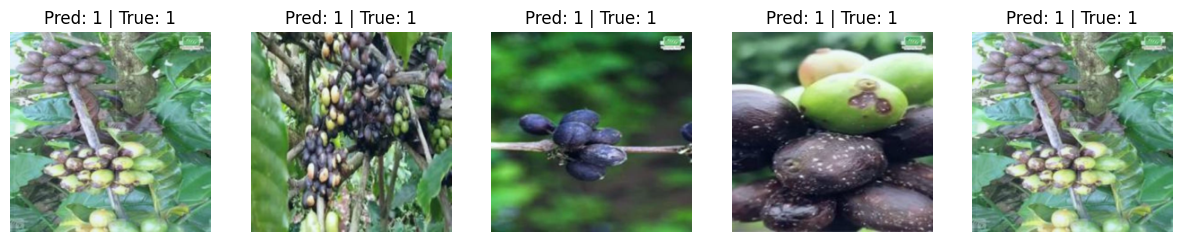

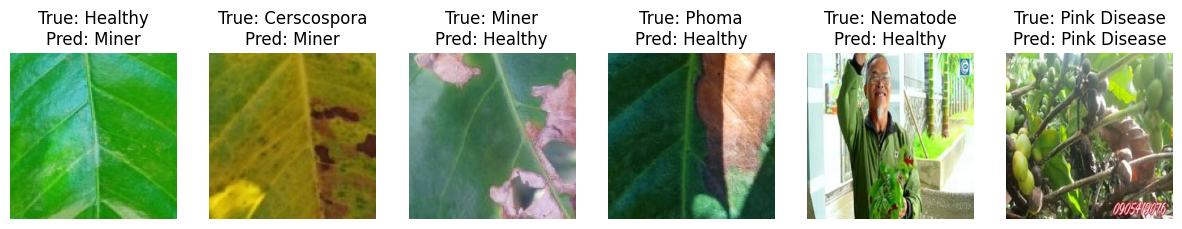

✅ All experiments completed! Results saved in 'results.csv'.


In [ ]:
csv_filename = "results.csv"
if not os.path.exists(csv_filename):
    pd.DataFrame(columns=["Experiment", "Episode", "Phase", "Loss", "Accuracy"]).to_csv(csv_filename, index=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
scaler = GradScaler() 

# Training loop
for exp_num, exp in enumerate(experiments):
    print(f"\U0001F680 Experiment {exp_num+1} | LR={exp['lr']}, Embedding={exp['embedding_dim']}, Backbone={exp['backbone']}")
    
    # Initialize model & optimizer
    model = ProtoNet(
        backbone=exp["backbone"],
        embedding_dim=exp["embedding_dim"],
        pretrained_path=exp.get("pretrained_path")
    ).to(device)

    # Check the model if classification layer is correct
    print(model.fc)

    optimizer = optim.Adam(model.parameters(), lr=exp["lr"], weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.9)

    num_episodes = exp["num_episodes"]
    results = []
    train_iterator = iter(fewshot_dataloader)

    model.train()
    for episode in range(num_episodes):
        # Get the next batch, refresh iterator if needed
        try:
            batch = next(train_iterator)
        except StopIteration:
            train_iterator = iter(fewshot_dataloader)
            batch = next(train_iterator)

        support_images, support_labels, query_images, query_labels = batch
        support_images, support_labels = support_images.squeeze(0).to(device), support_labels.squeeze(0).to(device)
        query_images, query_labels = query_images.squeeze(0).to(device), query_labels.squeeze(0).to(device)
        # Compute loss
        prototypes = compute_prototypes(support_images, support_labels, model)
        predictions = classify_query(prototypes, query_images, model)
        loss = F.cross_entropy(predictions, query_labels)

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        # Compute accuracy
        acc = (predictions.argmax(dim=1) == query_labels).float().mean().item()
        

        if episode % 100 == 0:
            print(f"[Exp {exp_num+1}] Episode {episode}: Loss={loss.item():.6f}, Acc={acc:.2f}")
            results.append({"Experiment": exp_num+1, "Episode": episode, "Phase": "Train", "Loss": loss.item(), "Accuracy": acc})
    # Evaluation
    test_loss, test_acc = evaluate(model, test_dataloader, device)
    results.append({"Experiment": exp_num+1, "Episode": num_episodes, "Phase": "Test", "Loss": test_loss, "Accuracy": test_acc})
    print(f"[Exp {exp_num+1}] Test Loss={test_loss:.6f}, Test Acc={test_acc:.2f}")
    
    # Add visulize prediction
    visualize_predictions(model, test_dataloader, device, num_samples=)

    # save model
    torch.save(model.state_dict(), f"model/model_{exp['backbone']}.pth")
    # load model
    model.load_state_dict(torch.load(f"model/model_{exp['backbone']}.pth"))
    # Test classification with 7 images
    image_folder = "../data sample/"  # Update with your actual test image folder
    class_name = [
    "Healthy", "Cerscospora", "Rust", "Miner",
    "Phoma", "Nematode", "Pink Disease"
    ]
    # Load images and true labels
    test_images = []
    true_labels = []
    image_paths = []

    for label in class_name:
        img_path = os.path.join(image_folder, f"{label}/1.jpg")
        if os.path.exists(img_path):
            image = Image.open(img_path).convert("RGB")
            image = transform(image)
            test_images.append(image)
            true_labels.append(label)
            image_paths.append(img_path)

    # Stack images into a batch
    test_images = torch.stack(test_images).to(device)

    with torch.no_grad():
        predictions = model(test_images)  # Get embeddings
        predicted_classes = torch.argmax(predictions, dim=1)  # Get predicted class index

    # Convert predictions to class names
    predicted_labels = [class_name[idx] for idx in predicted_classes.cpu().numpy()]

    # Visualize images with predictions
    fig, axes = plt.subplots(1, len(image_paths), figsize=(15, 5))  # Adjust for actual number of images

    for i, ax in enumerate(axes):
        img = Image.open(image_paths[i])
        ax.imshow(img)
        ax.set_title(f"True: {true_labels[i]}\nPred: {predicted_labels[i]}")
        ax.axis("off")

    plt.show()
    # Save results
    pd.DataFrame(results).to_csv(csv_filename, mode="a", header=False, index=False)

print("✅ All experiments completed! Results saved in 'results.csv'.")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.5179958].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0151556..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8781574..2.2885156].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0151556..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.843908..2.5005665].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.64].
Clippi

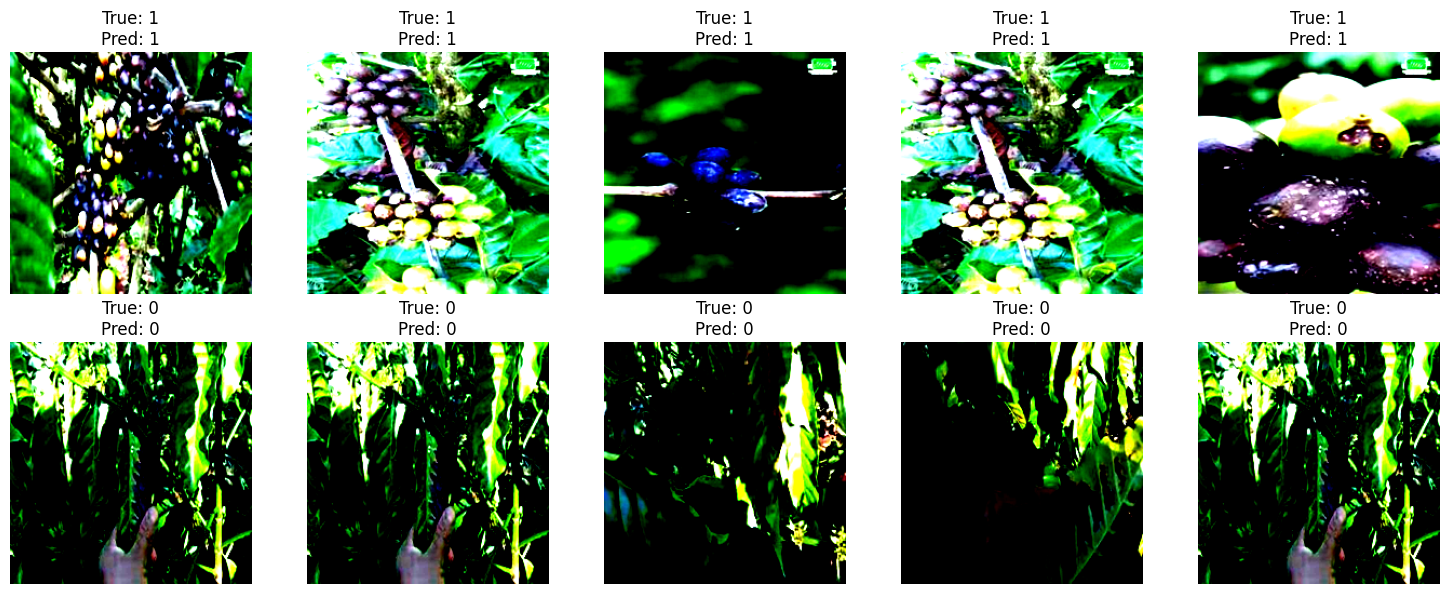

Accuracy: 0.14


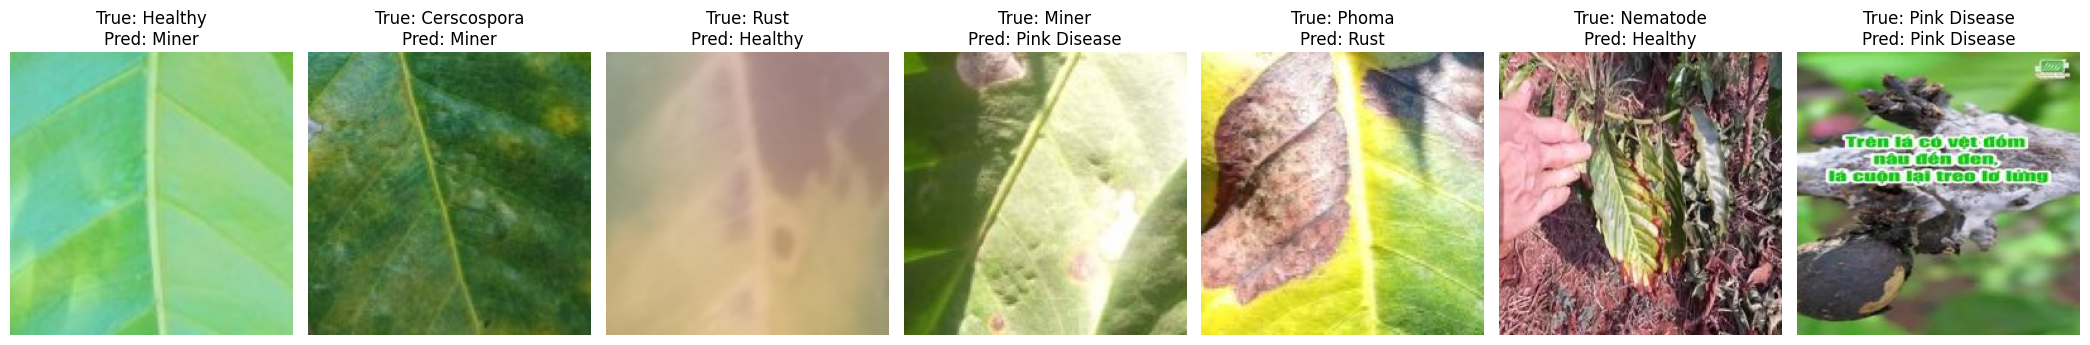

In [39]:
# Add visulize prediction
visualize_predictions(model, test_dataloader, device, num_samples=10)

model.load_state_dict(torch.load(f"model/model_{exp['backbone']}.pth"))
model.eval()

# Define classes
class_name = [
    "Healthy", "Cerscospora", "Rust", "Miner",
    "Phoma", "Nematode", "Pink Disease"
]
image_folder = "../data sample/"  # Update with your test image directory

# Load images
test_images, true_labels, image_paths = [], [], []
for label in class_name:
    img_path = os.path.join(image_folder, f"{label}/2.jpg")
    if os.path.exists(img_path):
        image = Image.open(img_path).convert("RGB")
        image = transform(image)
        test_images.append(image)
        true_labels.append(label)
        image_paths.append(img_path)

# Check if images are loaded
if len(test_images) == 0:
    raise ValueError("No test images found! Check file paths.")

# Convert to tensor batch
test_images = torch.stack(test_images).to(device)

# Get predictions
with torch.no_grad():
    predictions = model(test_images)
    predicted_classes = torch.argmax(predictions, dim=1).cpu().numpy()

# Convert predictions to class names
predicted_labels = [class_name[idx] for idx in predicted_classes]

# Compute accuracy
accuracy = (np.array(true_labels) == np.array(predicted_labels)).mean()
print(f"Accuracy: {accuracy:.2f}")

# **🖼️ Visualization**
num_images = len(image_paths)
fig, axes = plt.subplots(1, num_images, figsize=(num_images * 3, 5))

for i, ax in enumerate(axes):
    img = Image.open(image_paths[i])
    ax.imshow(img)
    ax.set_title(f"True: {true_labels[i]}\nPred: {predicted_labels[i]}")
    ax.axis("off")

plt.tight_layout()
plt.show()

In [40]:
print("True Indices:", [class_name.index(label) for label in true_labels])
print("Predicted Indices:", predicted_classes)

True Indices: [0, 1, 2, 3, 4, 5, 6]
Predicted Indices: [3 3 0 6 2 0 6]
